# Librerias

In [2]:
import dataAcquisition
import ReparameterizationTrick
import Encoder
import Decoder
import VAE
import loss
import train
import Predictor
import importlib
import numpy as np

#

# Data adquisition

In [3]:
importlib.reload(dataAcquisition)
#x_train, x_val, y_train, y_val, average_image_train, x_train_mixed, x_test_mixed, x_train_perm, y_train_perm

x_train, x_val, y_train, y_val, average_image, x_train_mix, x_test_mix,x_train_1, y_train_1 =  dataAcquisition.data_acquisition()

x_train(60k).shape:       (60000, 28, 28)
x_train_C.shape:     (55000, 28, 28, 1)
x_val_C.shape:     (5000, 28, 28, 1)
x_test_C.shape:      (10000, 28, 28, 1)
x_train.shape:       (55000, 28, 28)
x_val.shape:       (5000, 28, 28)
x_test.shape:       (10000, 28, 28)
x_train_mix.shape:  (55000, 28, 28)
x_test_mix.shape:  (10000, 28, 28)


# Encoder

In [4]:
importlib.reload(Encoder)
encoder = Encoder.encoder(x_train, y_train)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 784)       │          0 │ input_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 794)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ encoder_conditio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    101,760 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,276 (399.52 KB)

 Trainable params: 102,276 (399.52 KB)

 Non-trainable params: 0 (0.00 B)

# Decoder


In [5]:
importlib.reload(Decoder)
decoder = Decoder.decoder(x_train, y_train)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z_sampling          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12)        │          0 │ z_sampling[0][0], │
│ (Concatenate)       │                   │            │ decoder_conditio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      1,664 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 784)       │    101,136 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 28, 28, 1) │          0 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,800 (401.56 KB)

 Trainable params: 102,800 (401.56 KB)

 Non-trainable params: 0 (0.00 B)

VAE

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 2),       │    102,276 │ input_img[0][0],  │
│ (Functional)        │ (None, 2), (None, │            │ encoder_conditio… │
│                     │ 2)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 28, 28, 1) │    102,800 │ encoder[0][2],    │
│ (Functional)        │                   │            │ decoder_conditio… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 205,076 (801.08 KB)

 Trainable params: 205,076 (801.08 KB)

 Non-trainable params: 0 (0.00 B)

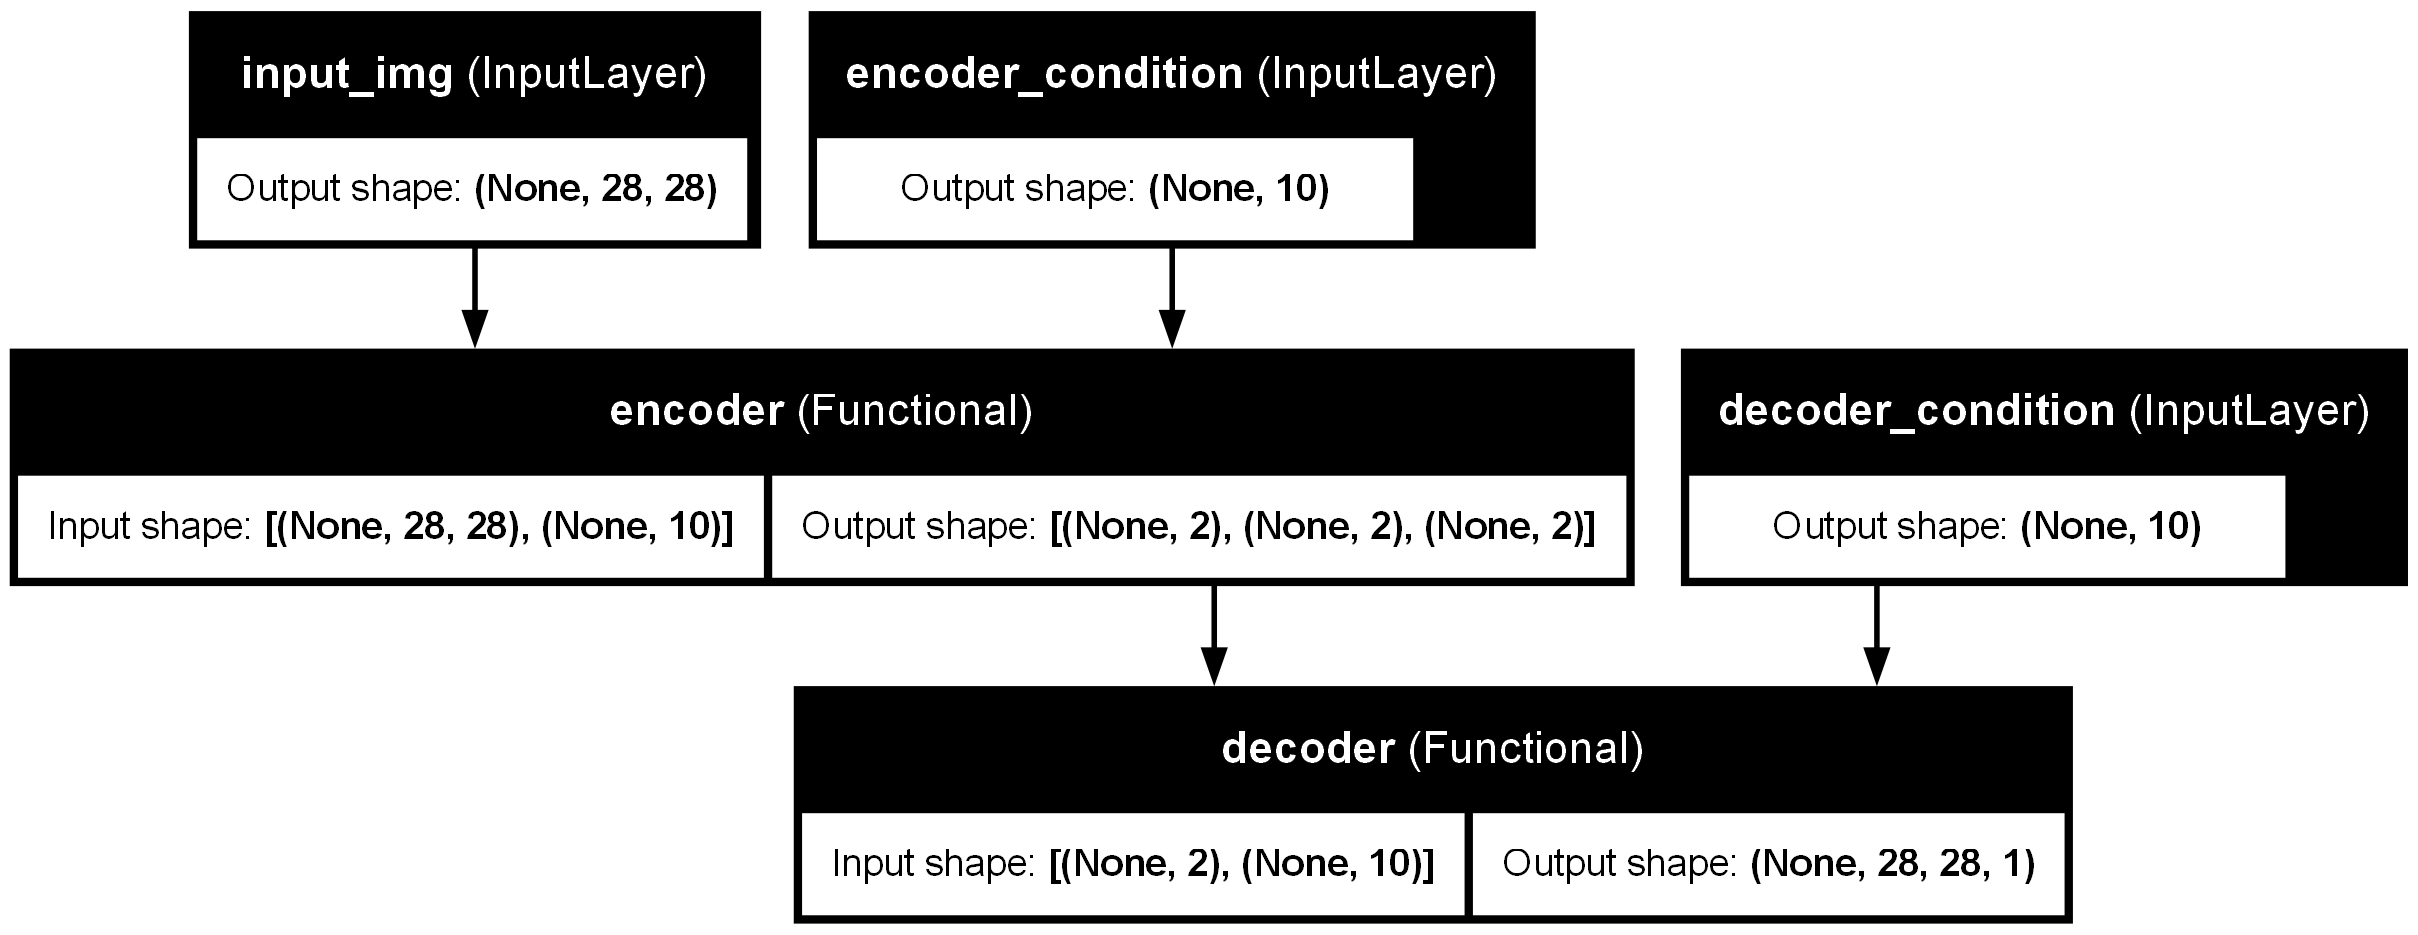

In [6]:
importlib.reload(VAE)
n_cond = np.shape(y_train)[1]  
vae =  VAE.Vae(encoder,decoder, show_model=True)

# Compile

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


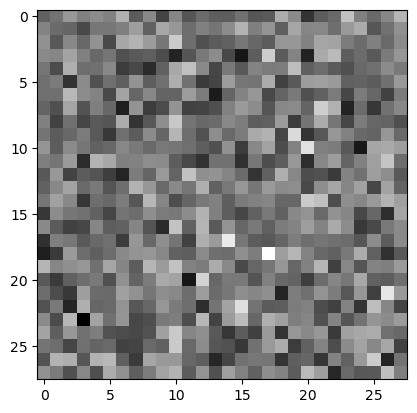

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(loss)
# Optimizer ------------------------------------------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile --------------------------------------------------------------------
vae.compile(optimizer, loss=loss.vae_loss) #cambiar nombre

img = np.expand_dims(x_train[0], axis=0)
cond = np.expand_dims(y_train[0], axis=0)
salida = vae.predict([img, cond,cond])

reconstruccion = salida[0].reshape(28, 28)
plt.imshow(reconstruccion, cmap='gray')

# Train

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 30.4118 - val_loss: 29.5372
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


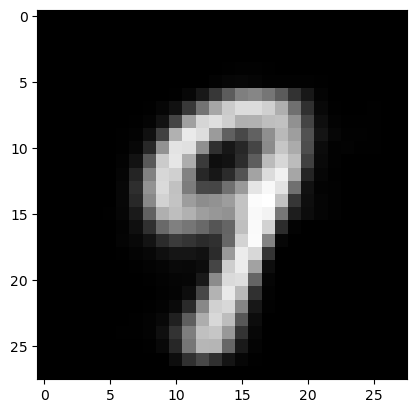

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 30.1768 - val_loss: 29.3553
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


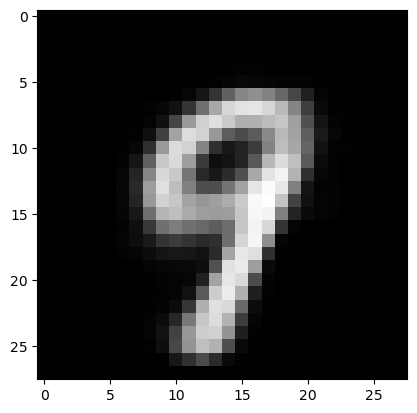

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 29.9645 - val_loss: 29.1992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


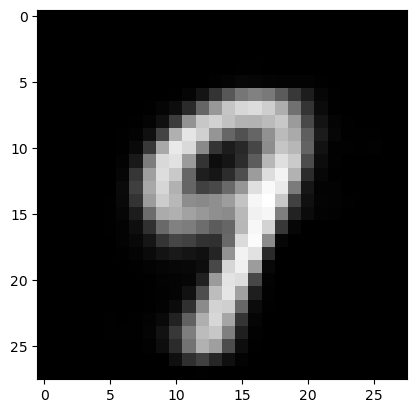

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 29.8308 - val_loss: 29.0538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


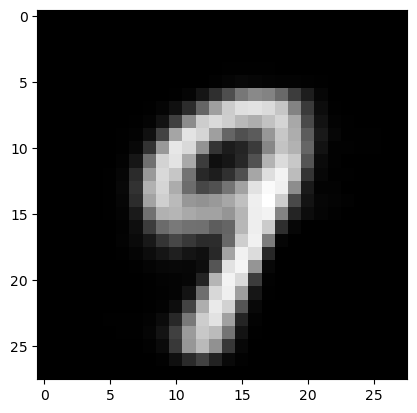

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 29.7372 - val_loss: 28.9142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


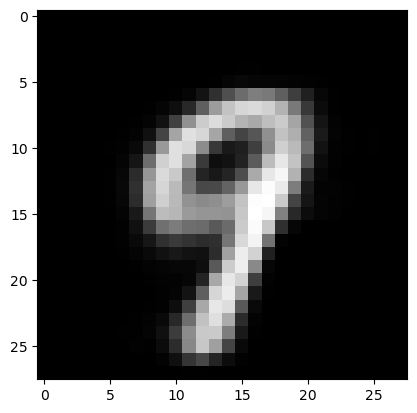

In [19]:
salida = vae.predict([img, cond,cond])
reconstruccion = salida[0].reshape(28, 28)
plt.imshow(reconstruccion, cmap='gray')

for i in range(5):
    train.train(vae, x_train, y_train, x_val, y_val)
    salida = vae.predict([img, cond,cond])
    reconstruccion = salida[0].reshape(28, 28)
    plt.imshow(reconstruccion, cmap='gray')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


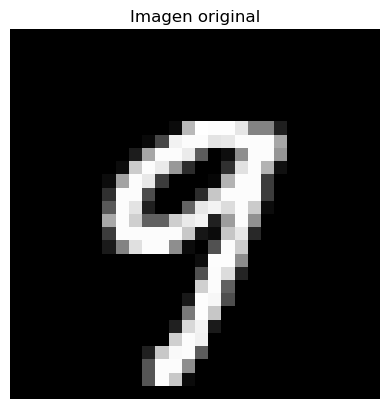

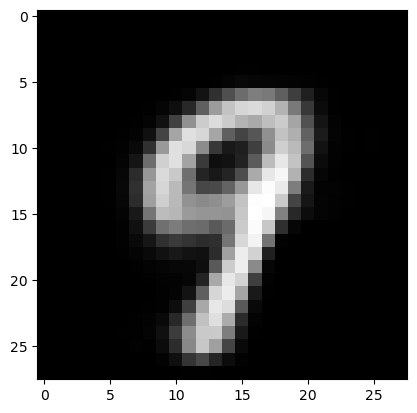

In [20]:
img = np.expand_dims(x_train[45], axis=0)
cond = np.expand_dims(y_train[45], axis=0)
salida = vae.predict([img, cond,cond])

reconstruccion = salida[0].reshape(28, 28)
plt.imshow(img[0], cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()
plt.imshow(reconstruccion, cmap='gray')

Model: "predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ original_input (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (ReshapeLayer)    │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,186 (196.04 KB)

 Trainable params: 50,186 (196.04 KB)

 Non-trainable params: 0 (0.00 B)

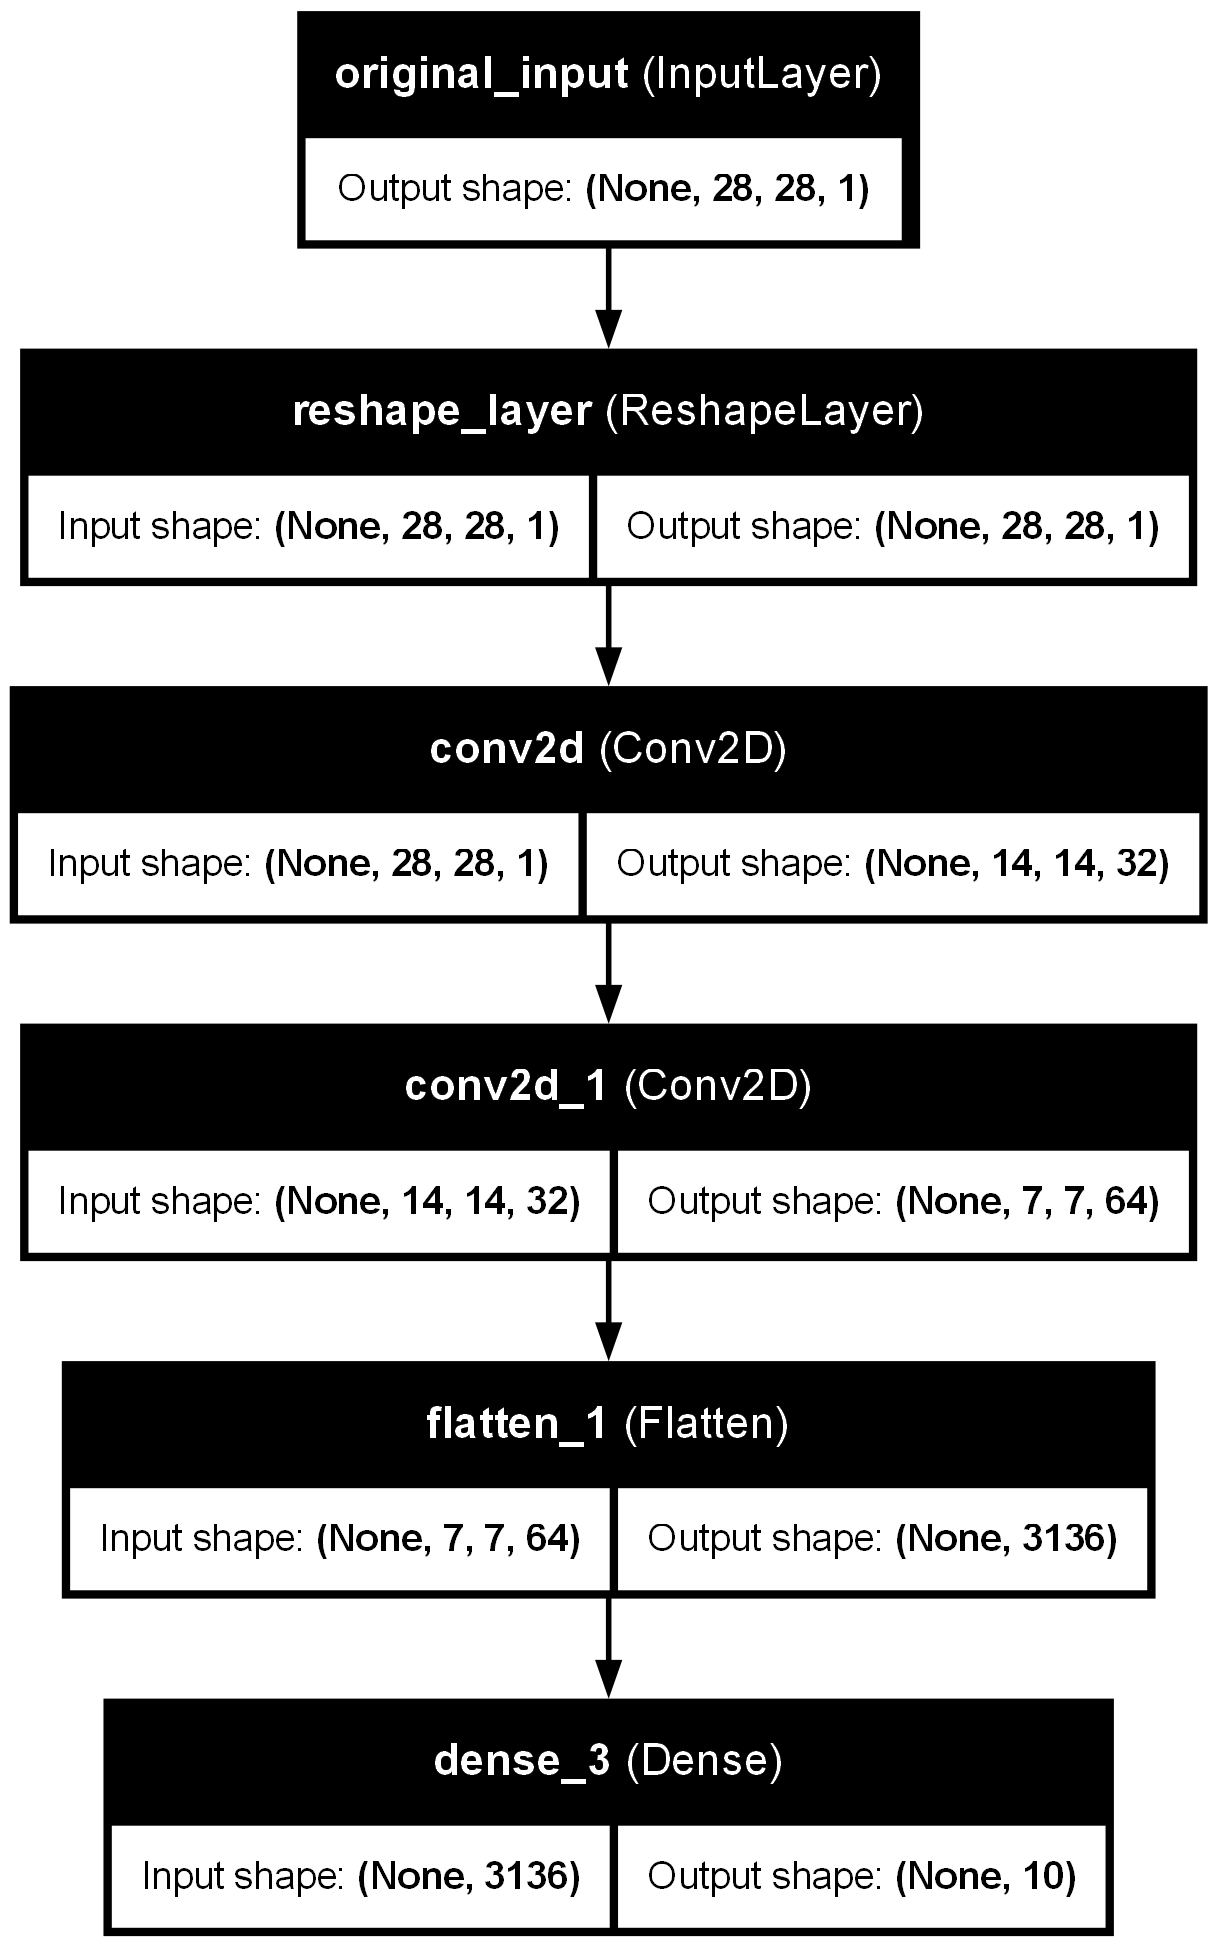

In [10]:
importlib.reload(Predictor)
predictor_c = Predictor.predictor()

(1, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


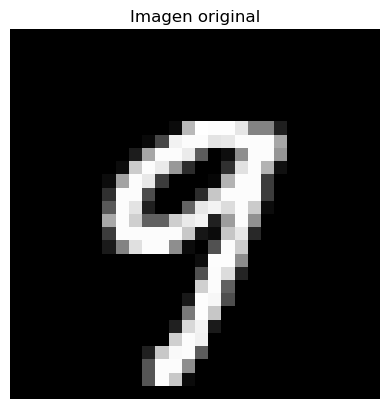

In [11]:
importlib.reload(Predictor)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
predictor_c.compile(optimizer, loss="categorical_crossentropy")
print(img.shape)
prediccion = np.argmax( predictor_c.predict(img))
img[0].reshape(28, 28)
plt.imshow(img[0], cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()


In [12]:
for i in range(5): 
    #reconstruccion = prediccion[0].reshape(28, 28)
    print(f"prediccion  {prediccion}")
    prediccion = np.argmax(predictor_c.predict(img))


    predictor_c.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        epochs=1,
        validation_data=(x_val, y_val)  # Include validation data
        )

prediccion  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.7189 - val_loss: 0.1115
prediccion  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1202 - val_loss: 0.0770
prediccion  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0757 - val_loss: 0.0577
prediccion  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0591 - val_loss: 0.0560
prediccion  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0475 - val_loss: 0.0544


(55000, 28, 28)


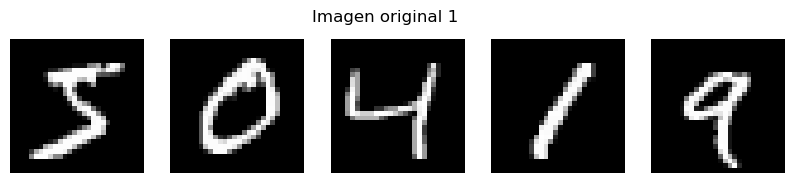

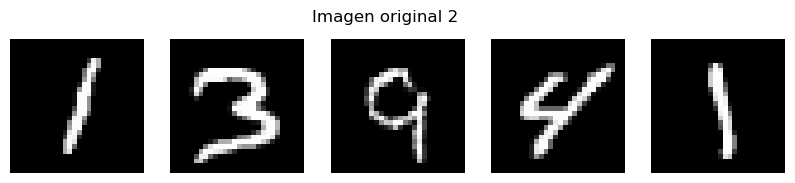

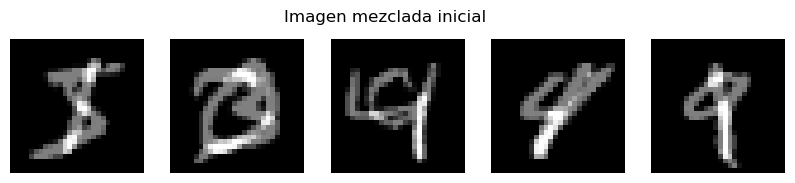

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
ITERACIÓN A: 0


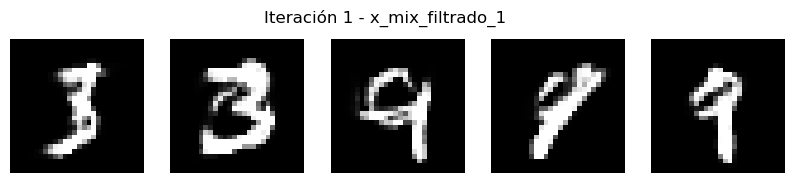

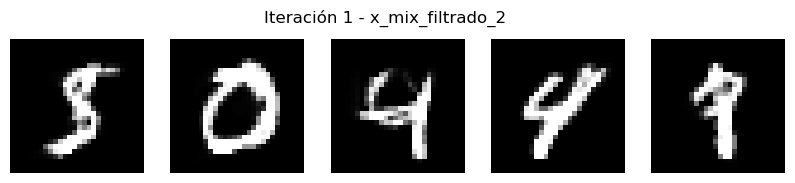

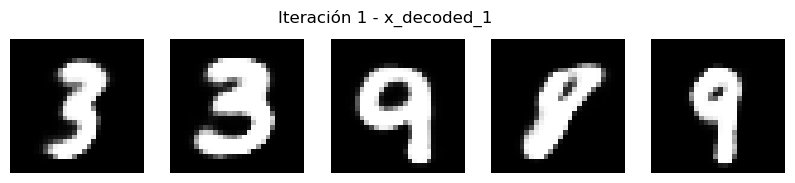

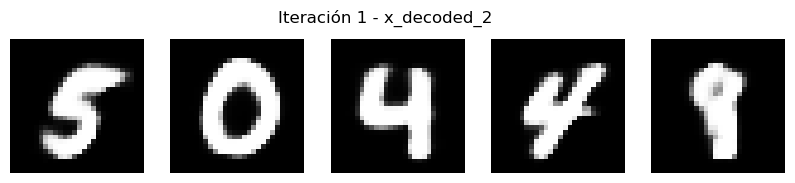

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
tf.Tensor([0.492403   0.320759   0.45176893 ... 0.5597765  0.40333807 0.4961805 ], shape=(55000,), dtype=float32)
tf.Tensor([0.3386874  0.26694444 0.5482877  ... 0.43796313 0.50864536 0.25372982], shape=(55000,), dtype=float32)
tf.Tensor([0.4155452  0.29385173 0.5000283  ... 0.4988698  0.45599172 0.37495518], shape=(55000,), dtype=float32)
tf.Tensor([0.58369154 0.6445136  0.5082701  ... 0.35458562 0.53944117 0.7426281 ], shape=(55000,), dtype=float32)
tf.Tensor([0.3992901  0.5201835  0.683316   ... 0.4035459  0.6893028  0.40089297], shape=(55000,), dtype=float32)
tf.Tensor([0.49149084 0.5823486  0.595793   ... 0.37906575 0.614372   0.57176054], shape=(55000,), dtype=float32)
PSNR mean: 13.658475 SSIM mean: 0.5731208
Batched PSNR Mean: 13.658475
Batched PSNR Std: 1.6984321
tf

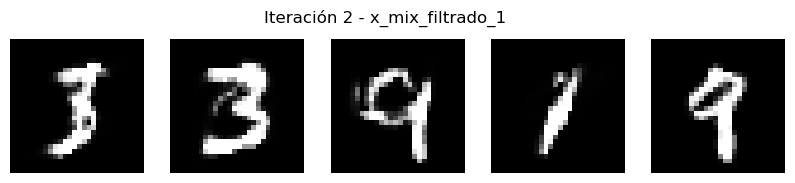

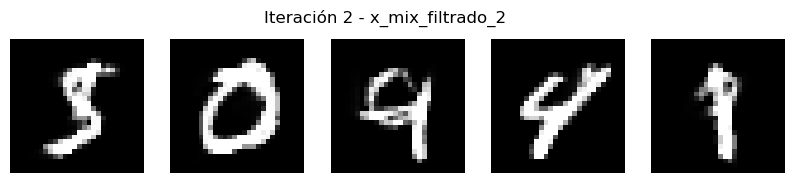

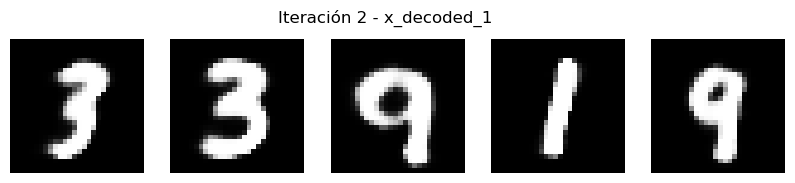

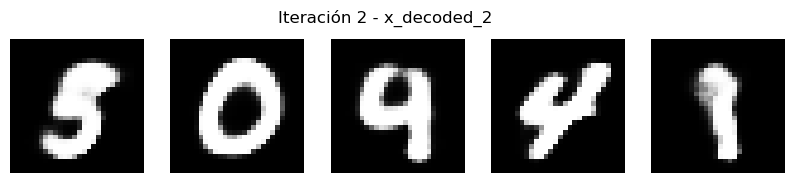

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
tf.Tensor([0.45975074 0.20321715 0.42472726 ... 0.7099254  0.40383285 0.31565532], shape=(55000,), dtype=float32)
tf.Tensor([0.28773797 0.2414976  0.6383867  ... 0.58202034 0.4565484  0.14662111], shape=(55000,), dtype=float32)
tf.Tensor([0.37374437 0.22235738 0.53155696 ... 0.64597285 0.43019062 0.23113821], shape=(55000,), dtype=float32)
tf.Tensor([0.65160465 0.70151395 0.47491473 ... 0.19768694 0.590796   0.91257024], shape=(55000,), dtype=float32)
tf.Tensor([0.41840258 0.54687554 0.69294775 ... 0.27979255 0.70341885 0.5681276 ], shape=(55000,), dtype=float32)
tf.Tensor([0.5350036  0.62419474 0.5839312  ... 0.23873974 0.6471074  0.74034894], shape=(55000,), dtype=float32)
PSNR mean: 14.685417 SSIM mean: 0.6324719
Batched PSNR Mean: 14.685417
Batched PSNR Std: 2.2318757
tf

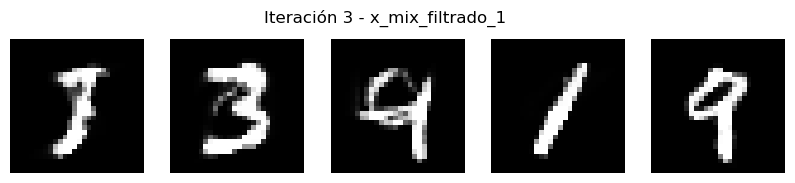

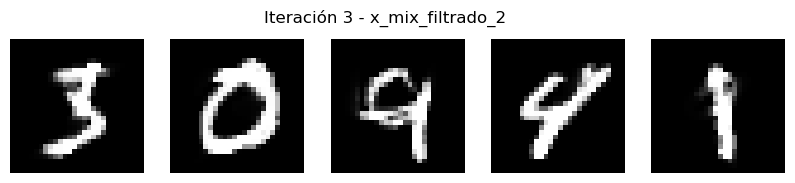

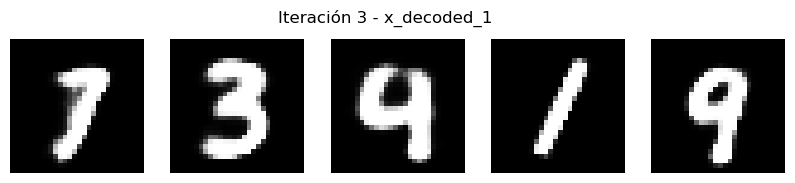

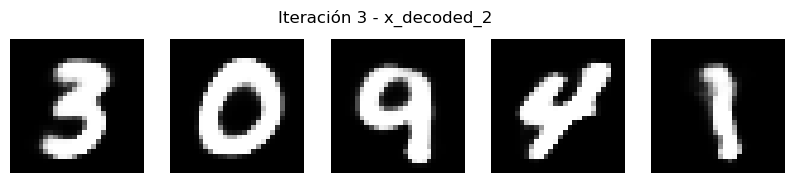

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
tf.Tensor([0.3725139  0.18805405 0.48809156 ... 0.7769311  0.38094607 0.26939723], shape=(55000,), dtype=float32)
tf.Tensor([0.27261323 0.23589271 0.6743937  ... 0.8245661  0.4008562  0.15301791], shape=(55000,), dtype=float32)
tf.Tensor([0.32256356 0.21197338 0.5812426  ... 0.8007486  0.39090115 0.21120757], shape=(55000,), dtype=float32)
tf.Tensor([0.6808324  0.7077609  0.4596988  ... 0.16007668 0.6391367  0.9098657 ], shape=(55000,), dtype=float32)
tf.Tensor([0.52802664 0.5603144  0.6097286  ... 0.20856224 0.742129   0.6533163 ], shape=(55000,), dtype=float32)
tf.Tensor([0.6044295  0.6340376  0.5347137  ... 0.18431947 0.6906328  0.781591  ], shape=(55000,), dtype=float32)
PSNR mean: 15.098598 SSIM mean: 0.6552701
Batched PSNR Mean: 15.098598
Batched PSNR Std: 2.3481538
tf

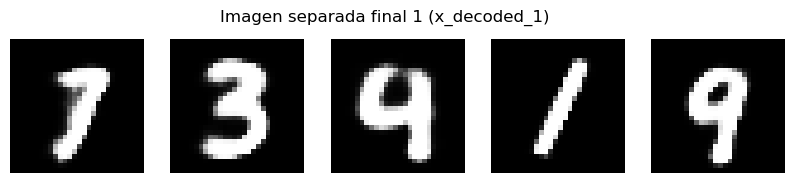

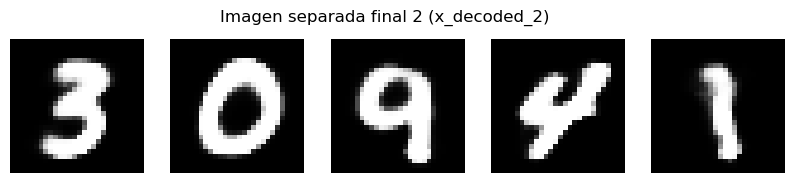

In [21]:
import inferencias
importlib.reload(inferencias)
#importlib.reload(outcomes)
print(x_train.shape)
import inferencias

# Suponiendo que ya tienes definidos:
# x_train, x_train_1, y_train, y_train_1, predictor, encoder, decoder


inferencias.inferncia_modelo(x_train, x_train_1, y_train, predictor_c, encoder, decoder, y_train_1)